# Week 8 Markov Simulation Project

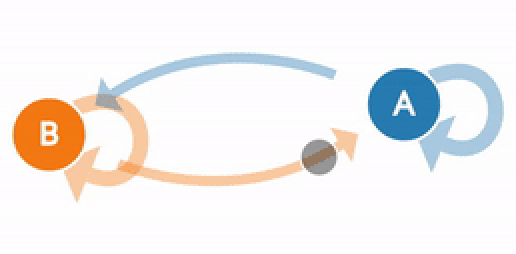




# Objective of the Project

The objective of this week's project is to simulate supermarket's behavior by using Markov Simulation and Object Oriented Programming 



# Imports

In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from datetime import datetime, time


ModuleNotFoundError: No module named 'seaborn'

# EDA

In [ ]:
df = pd.concat(map(lambda f: pd.read_csv(f, delimiter=';'),glob.glob('data/*.csv')))
df.head()

## Breakdown Timestamp

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")
df['hour']= df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['weekday'] = df['timestamp'].dt.day_name()


## Created unique Customer IDs

In [ ]:
def create_unique_customer_id(row):
    return row['timestamp'].dayofyear * 100000 + row['customer_no']

df['customer_id'] = df.apply(lambda row: create_unique_customer_id(row), axis=1)

In [ ]:
df = df.drop(['customer_no'], axis = 1)
df

In [ ]:
df.info()

## Calculate the total number of customers in each section and per day of week

In [ ]:
df_eda = df.copy()

In [ ]:
customers = df_eda.groupby('location')['customer_id'].count().reset_index(name='no. of customers')
customers

In [ ]:
plt.subplots(figsize = [20,8])
ax = sns.barplot(data = customers, x = 'location', y = 'no. of customers', palette = 'Set2')
ax.set(title = 'Total Number of Customer in Each Location', xlabel='Locations', ylabel='No. of Customers')

In [ ]:
customers_dow = df_eda.groupby(['location','weekday'])['customer_id'].count().reset_index(name='no. of customers')
customers_dow.head(5)

In [ ]:
plt.subplots(figsize = [20,8])
ax = sns.barplot(data = customers_dow, x = 'location', y = 'no. of customers', palette = 'Set2', hue = 'weekday',
                hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday'])
ax.set(title = 'Total Number of Customer in Each Location Per DOW', xlabel='Locations', ylabel='No. of Customers')

## Calculate the total number of customers in each location over time

In [ ]:
customer_lot = df_eda.groupby(['location','hour', 'weekday'])['customer_id'].count().reset_index(name='no. of customers')
customer_lot.head()

In [ ]:
plt.subplots(figsize = [20,8])
ax = sns.pointplot(data = customer_lot, x = 'hour', y = 'no. of customers', palette = 'Set2', hue = 'location')
ax.set(title = 'Daily Total Number of Customer at Each Location Per Hour', xlabel='hour', ylabel='No. of Customers')

## Display the number of customers at checkout over time

In [ ]:
customer_checkout = df_eda.groupby(['location','hour', 'weekday'])['customer_id'].count().reset_index(name='no. of customers')
customer_checkout = customer_checkout[customer_checkout.location == 'checkout']
customer_checkout.head(5)

In [ ]:
plt.subplots(figsize = [20,8])
ax = sns.pointplot(data = customer_checkout, x = 'hour', y = 'no. of customers', palette = 'Set2', hue = 'weekday',
                  hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday'])
ax.set(title = 'Daily Total Number of Customer at Checkout Per Hour', xlabel='hour', ylabel='No. of Customers')

## Calculate the time duration each customer spend in the market

In [ ]:
time_in = df_eda.groupby(['customer_id', 'weekday'])['timestamp'].min() 
time_out = df_eda.groupby(['customer_id', 'weekday'])['timestamp'].max()

duration = (time_out - time_in).dt.seconds.reset_index(name = 'duration in seconds')
duration

 ## Calculate the time duration each customer spent in every location

In [ ]:
duration_loc = df_eda.groupby(['customer_id', 'timestamp', 'location']).all().reset_index()

duration_loc['spenttime'] = duration_loc.groupby('customer_id')['timestamp'].diff().shift(-1)
dummies=pd.get_dummies(duration_loc.location)
dummies.values[dummies!=0]=duration_loc.spenttime.dt.total_seconds()/60
duration_loc = duration_loc.join(dummies)
duration_loc = duration_loc.drop(['hour','minute','weekday','timestamp','location','spenttime'], axis=1)
duration_loc = duration_loc.groupby('customer_id').sum()
customer_dur = duration_loc 
customer_dur.head(10)

## Calculate the total number of customers in the supermarket over time.

In [ ]:
customer_hourly = df_eda.groupby(['hour', 'weekday'])['customer_id'].count().reset_index(name='no. of customers')
customer_hourly.head(10)

In [ ]:
plt.subplots(figsize = [20,8])
ax = sns.pointplot(data = customer_hourly, x = 'hour', y = 'no. of customers', palette = 'Set2', hue = 'weekday',
                  hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday'])
ax.set(title = 'Daily Total Number of Customer in the Supermarket Per Hour', xlabel='hour', ylabel='No. of Customers')

## Estimated total revenue per minute for each location


In [ ]:
revenue_per_minute = df_eda.groupby(['timestamp','location']).all().reset_index()
revenue_per_minute = revenue_per_minute.drop(['hour','minute','weekday','customer_id'], axis=1)
revenue_per_minute['revenue'] = revenue_per_minute['location'].map({'dairy': 5, 'fruit': 4, 'spices': 3, 'drinks': 6})
revenue_per_minute = revenue_per_minute.dropna()
revenue_per_minute = revenue_per_minute.groupby(['timestamp','location']).sum()
revenue_per_minute

In [ ]:
revenue_total_loc = revenue_per_minute.groupby(['location']).sum()
revenue_total_loc

# Transition Probability Matrix

In [ ]:
df_eda.head(5)

In [ ]:
trans = df_eda.groupby(['customer_id', 'timestamp', 'location']).all().reset_index()
trans['after'] = trans.groupby('customer_id')['location'].shift(-1)
trans = trans.rename(columns={'location':'before'})
trans = trans.drop(['customer_id','timestamp','hour','minute','weekday'], axis=1)
trans = trans.fillna('checkout')
trans.head(5)

In [ ]:
matrix = pd.crosstab(trans['before'], trans['after'], normalize=0)
matrix

In [ ]:
plt.figure(figsize = [10,5])

sns.heatmap(matrix.corr(), annot = True, vmin=-1, vmax=1, center= 0)

# Markov Simulations

In [ ]:
P = matrix.values
P

## Initial State

In [ ]:
vector_0 = np.array([0, 0.5, 0.25, 0.25, 0])
vector_0

In [ ]:
vector_1 = np.dot(vector_0, P)
vector_1

In [ ]:
vector_2 = np.dot(vector_1, P)
vector_2

## Vector Chains

In [ ]:
vector = vector_0
print(vector)
vector_n = 10

In [ ]:
new_vector = np.dot(vector_0, P)
new_vector_list = []

for i in range(vector_n):
    new_vector = np.dot(new_vector, P)
    new_vector_list.append(new_vector)
                  
print(new_vector_list)

# Supermarket Simulation

In [ ]:
df_sim = df_eda.reset_index()
df_sim

In [ ]:
class Customer:
    
    
    def __init__(self, id, state, t_mat):
        self.id = id
        self.state = state
        self.t_mat = t_mat
        self.checkout_visits = 0
        self.a = t_mat.columns.values.tolist()
        
    def __repr__(self):
        return f'{self.id} is in {self.state}'
    
    def is_active(self):
        """ the customer is active until he enters the state 
        'checkout' a second time
        
        Returns:
        boolean: True if checkout state is entered a second time
        """
        return self.checkout_visits < 2
    
    def next_state(self):
        """Moves customer to the next department
        
        The next step is determined by a weighted random choice. The weights can be found
        in the transformation matrix and are selected by the current state.
        """
        p = self.t_mat.loc[self.state].to_list()
        self.state = np.random.choice(self.a, p=p)
        if (self.state) == 'checkout':
            self.checkout_visits = self.checkout_visits + 1


In [ ]:
matrix.loc['dairy'].to_list()

In [ ]:
c1 = Customer(df_sim.at[0,'customer_id'], df_sim.at[0,'location'], matrix)
print(c1)

In [ ]:
while c1.is_active():
    c1.next_state()
    print(c1)

In [2]:

class Supermarket:
    def __init__(self, customers):
        
        """ initializes the supermarket object with a list of customers and a dataframe
        for the history
        
        Parameters:
        customers: List of customers in the supermarket
        """
        self.customers = customers
        self.time = time (8,0)
        self.df = pd.DataFrame(columns=['time','customer_id','location'])
        for c in self.customers:
            self.df = self.df.append({'time':self.time,'customer_id':c.id,'location':c.state}, ignore_index=True)

        
    def get_time(self):
        return self.time
    
    def next_minute(self):
        """each minute all customers move to the next department
        
        TODO: improve usage of time so that more than one hour can be used
        """
        self.time = time(self.time.hour, self.time.minute +1 )
        for c in self.customers:
            c.next_state()
            self.df = self.df.append({'time':self.time,'customer_id':c.id,'location':c.state}, ignore_index=True)
        
    def print_customers(self):
        print(self.df)
        print('----------')
        
    def is_active(self):
        """ as long as at least one customer is active the whole supermarket is active
        otherwise the history is written to a csv file
        
        Returns:
        boolean: True as long customers are moving around
        """
        for c in self.customers:
            if (c.is_active()):
                return True
        self.df.to_csv('supermarketadventure.csv',index=False)
        return False
    
    def __repr__(self):
        self.print_customers()
        return f'{len(self.customers)} customers running around at {self.time}'

In [ ]:
df_sim2 = df_sim.groupby(['customer_id',]).first().reset_index()

customers = []
for i in range(0,14):
    customers.append(Customer(df_sim2.at[i,'customer_id'], df_sim2.at[i,'location'], matrix))
customers

In [ ]:
supermarket_adventures = Supermarket(customers)
print(supermarket_adventures)
while supermarket_adventures.is_active():
    supermarket_adventures.next_minute()
    print(supermarket_adventures)

In [ ]:
Supermarket()